# Exploring Dandiset 001361: A flexible hippocampal population code for experience relative to reward

> **Note**: This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results and verify calculations where appropriate.

## Overview

This notebook explores [Dandiset 001361 (version 0.250406.0045)](https://dandiarchive.org/dandiset/001361/0.250406.0045), which contains two-photon calcium imaging data from hippocampal area CA1 and behavioral data recorded during virtual reality navigation in mice.

The dataset is part of a study investigating how hippocampal neurons encode experiences relative to rewards. Using a virtual reality navigation task where reward locations were changed, the researchers demonstrated that hippocampal neurons flexibly encoded both spatial information and reward-relative positions.

In this notebook, we'll:
1. Load and explore the Dandiset metadata
2. Examine the NWB file structure
3. Visualize behavioral data such as position, speed, licks, and rewards
4. Analyze neural activity data from calcium imaging
5. Explore relationships between neural activity and behavior

## Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import remfile
import pynwb
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient
import pandas as pd
import seaborn as sns

# Set plotting parameters
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]

## Exploring the Dandiset Metadata

In [2]:
# Connect to the DANDI API
client = DandiAPIClient()

# Get the Dandiset metadata
dandiset = client.get_dandiset("001361", "0.250406.0045")
metadata = dandiset.get_raw_metadata()

# Print basic information
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Dandiset DOI: {metadata['doi']}")
print(f"Dandiset version: {metadata['version']}")
print(f"Contributors: {', '.join([c['name'] for c in metadata['contributor'] if 'Author' in c['roleName']])}")

Dandiset name: A flexible hippocampal population code for experience relative to reward
Dandiset URL: https://dandiarchive.org/dandiset/001361/0.250406.0045
Dandiset DOI: 10.48324/dandi.001361/0.250406.0045
Dandiset version: 0.250406.0045
Contributors: 


Let's examine the description to understand the research context:

In [3]:
print(metadata['description'])

2-photon imaging and behavioral data from hippocampal area CA1 during virtual reality navigation in mice. Included in Sosa, Plitt, & Giocomo, "A flexible hippocampal population code for experience relative to reward," Nature Neuroscience.

To reinforce rewarding behaviors, events leading up to and following rewards must be remembered. Hippocampal place cell activity spans spatial and non-spatial episodes, but whether hippocampal activity encodes entire sequences of events relative to reward is unknown. To test this, we performed two-photon imaging of hippocampal CA1 as mice navigated virtual environments with changing hidden reward locations. When the reward moved, a subpopulation of neurons updated their firing fields to the same relative position with respect to reward, constructing behavioral timescale sequences spanning the entire task. Over learning, this reward-relative representation became more robust as additional neurons were recruited, and changes in reward-relative firing o

## Exploring the Available Files

In [4]:
# Get a list of assets
assets = list(dandiset.get_assets())

# Print the number of files
print(f"Total number of files: {len(assets)}")

# Sample a few files to see the naming pattern
print("\nSample files:")
for i in range(min(5, len(assets))):
    print(f"  {assets[i].path}")

# Get subject and session counts
subjects = set([asset.path.split('/')[0] for asset in assets if '/' in asset.path])
print(f"\nNumber of subjects: {len(subjects)}")
print(f"Subjects: {', '.join(subjects)}")

Total number of files: 152

Sample files:
  sub-m11/sub-m11_ses-05_behavior+ophys.nwb
  sub-m11/sub-m11_ses-04_behavior+ophys.nwb
  sub-m11/sub-m11_ses-07_behavior+ophys.nwb
  sub-m11/sub-m11_ses-06_behavior+ophys.nwb
  sub-m11/sub-m11_ses-08_behavior+ophys.nwb

Number of subjects: 11
Subjects: sub-m15, sub-m7, sub-m14, sub-m19, sub-m13, sub-m18, sub-m3, sub-m12, sub-m4, sub-m17, sub-m11


Let's select one NWB file to work with for detailed exploration:

In [5]:
# Choose one of the files to work with
sample_file_path = "sub-m11/sub-m11_ses-05_behavior+ophys.nwb"

# Get the download URL for streaming
sample_file = next(dandiset.get_assets_by_glob(sample_file_path))
download_url = sample_file.download_url

print(f"Selected file: {sample_file_path}")
print(f"URL: {download_url}")

Selected file: sub-m11/sub-m11_ses-05_behavior+ophys.nwb


URL: https://api.dandiarchive.org/api/dandisets/001361/versions/0.250406.0045/assets/a22cc1da-b5e8-4fea-a770-7b83a6e79656/download/


## Loading and Exploring an NWB File

Let's load the selected NWB file using the streaming approach:

In [6]:
# Stream the file without downloading it
remote_file = remfile.File(download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the NWB file
print(f"Session ID: {nwb.session_id}")
print(f"Session Description: {nwb.session_description}")
print(f"Start Time: {nwb.session_start_time}")
print(f"Identifier: {nwb.identifier}")
print(f"Experimenter: {', '.join(nwb.experimenter)}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session ID: 05
Session Description: processed suite2p data
Start Time: 2023-02-25 00:00:00-08:00
Identifier: /data/InVivoDA/GCAMP11/25_02_2023/Env1_LocationA_to_C
Experimenter: Mari Sosa


### Subject Information

In [7]:
# Print subject information
subject = nwb.subject
print(f"Subject ID: {subject.subject_id}")
print(f"Species: {subject.species}")
print(f"Sex: {subject.sex}")
print(f"Date of Birth: {subject.date_of_birth}")

Subject ID: m11
Species: Mus musculus
Sex: M
Date of Birth: 2022-09-20 00:00:00-07:00


## Exploring the NWB File Structure

NWB files have a hierarchical structure that organizes different types of data. Let's explore the main components of this file.

In [8]:
# Get the available processing modules
processing_modules = list(nwb.processing.keys())
print("Processing modules:", processing_modules)

# List the acquisition data types
acquisition_types = list(nwb.acquisition.keys())
print("Acquisition data types:", acquisition_types)

Processing modules: ['behavior', 'ophys']
Acquisition data types: ['TwoPhotonSeries']


## Examining the Behavior Data

First, let's explore the behavioral data, which includes information about position, speed, reward zones, and licking.

In [9]:
# Access the behavior processing module
behavior = nwb.processing["behavior"]
behavior_data = behavior.data_interfaces["BehavioralTimeSeries"]

# Get the available behavioral measurements
behavioral_measurements = list(behavior_data.time_series.keys())
print("Available behavioral measurements:", behavioral_measurements)

Available behavioral measurements: ['Reward', 'autoreward', 'environment', 'lick', 'position', 'reward_zone', 'scanning', 'speed', 'teleport', 'trial number', 'trial_start']


### Position and Speed Data

Let's plot the position and speed of the animal during the session:

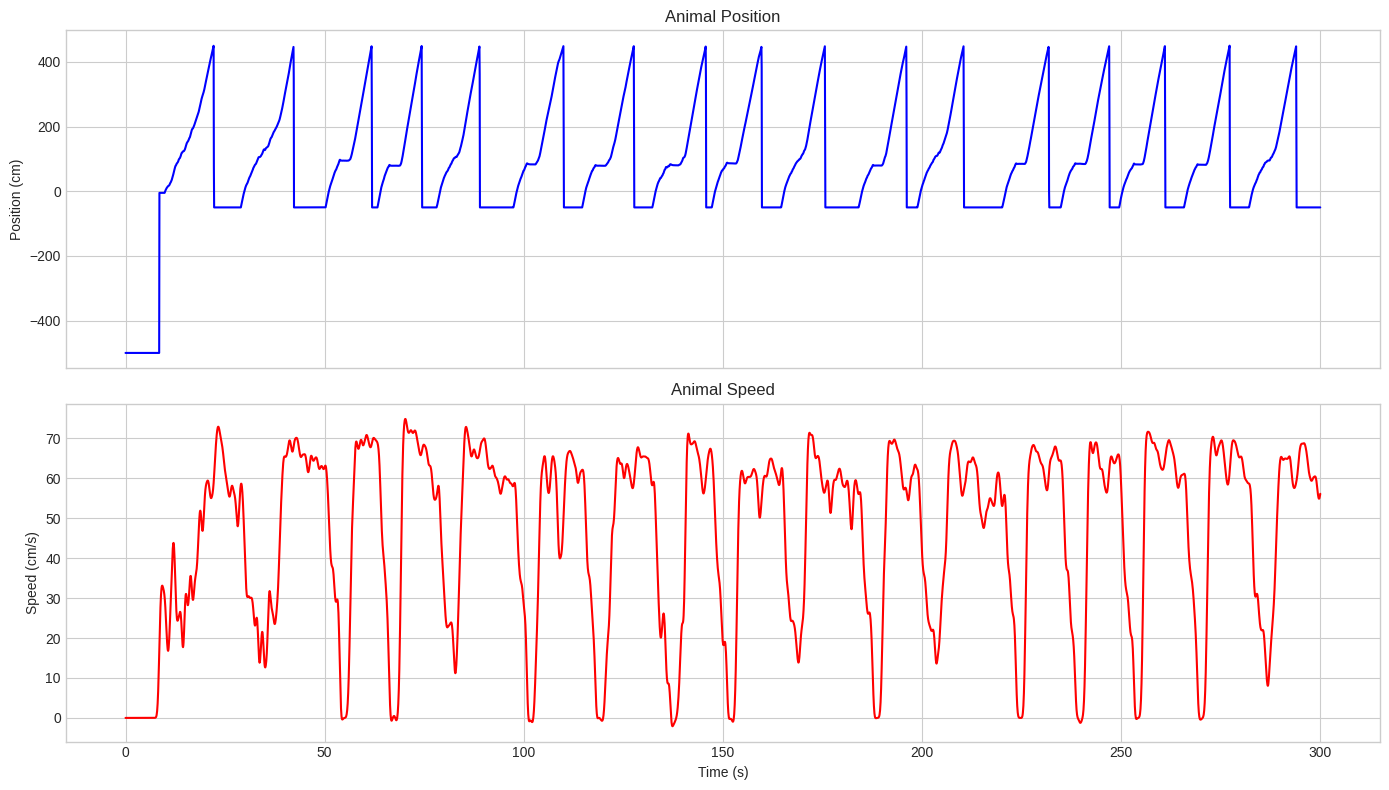

In [10]:
# Get position data
position = behavior_data.time_series["position"]
position_data = position.data[:]
position_timestamps = position.timestamps[:]

# Get speed data
speed = behavior_data.time_series["speed"]
speed_data = speed.data[:]
speed_timestamps = speed.timestamps[:]

# Create a time window for visualization (first 5 minutes)
time_window = 5 * 60  # 5 minutes in seconds
time_mask = position_timestamps < time_window

# Plot position and speed
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Position plot
ax1.plot(position_timestamps[time_mask], position_data[time_mask], 'b-')
ax1.set_ylabel('Position (cm)')
ax1.set_title('Animal Position')

# Speed plot
ax2.plot(speed_timestamps[time_mask], speed_data[time_mask], 'r-')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Speed (cm/s)')
ax2.set_title('Animal Speed')

plt.tight_layout()
plt.show()

Let's examine the position distribution over the entire session to understand where the animal spent most of its time:

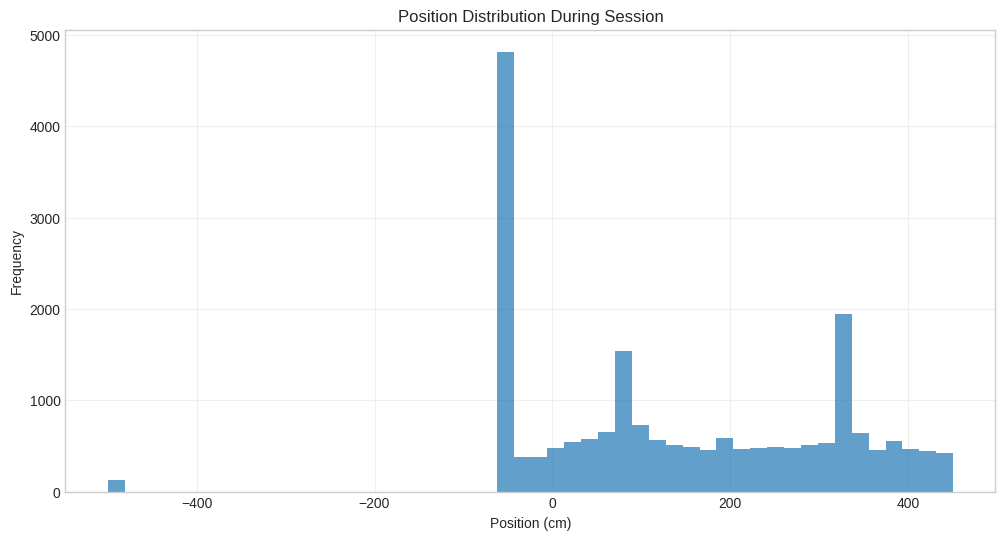

In [11]:
# Plot position histogram
plt.figure(figsize=(12, 6))
plt.hist(position_data, bins=50, alpha=0.7)
plt.xlabel('Position (cm)')
plt.ylabel('Frequency')
plt.title('Position Distribution During Session')
plt.grid(True, alpha=0.3)
plt.show()

### Licking and Reward Data

Now, let's explore the licking behavior and reward delivery:

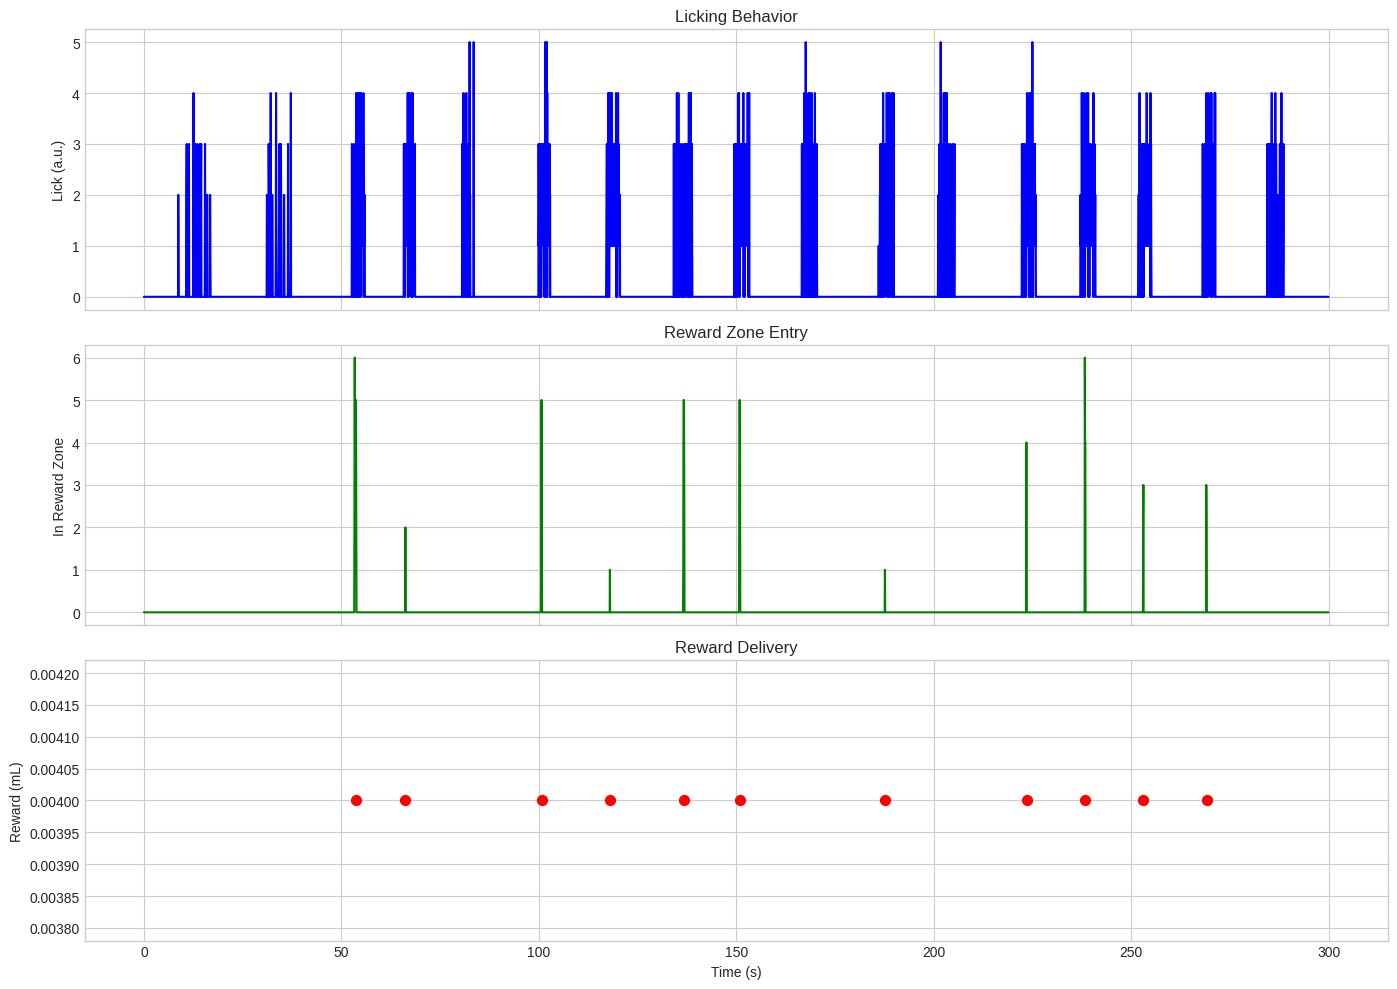

In [12]:
# Get lick data
lick = behavior_data.time_series["lick"]
lick_data = lick.data[:]
lick_timestamps = lick.timestamps[:]

# Get reward data
reward = behavior_data.time_series["Reward"]
reward_data = reward.data[:]
reward_timestamps = reward.timestamps[:]

# Get reward zone data
reward_zone = behavior_data.time_series["reward_zone"]
reward_zone_data = reward_zone.data[:]
reward_zone_timestamps = reward_zone.timestamps[:]

# Create a plot for licking and reward
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot licking behavior
ax1.plot(lick_timestamps[time_mask], lick_data[time_mask], 'b-')
ax1.set_ylabel('Lick (a.u.)')
ax1.set_title('Licking Behavior')

# Plot reward zone entry
ax2.plot(reward_zone_timestamps[time_mask], reward_zone_data[time_mask], 'g-')
ax2.set_ylabel('In Reward Zone')
ax2.set_title('Reward Zone Entry')

# Plot reward delivery
# Create a scatter plot for reward events
reward_mask = reward_timestamps < time_window
ax3.scatter(reward_timestamps[reward_mask], reward_data[reward_mask], 
           color='r', s=50, marker='o')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Reward (mL)')
ax3.set_title('Reward Delivery')

plt.tight_layout()
plt.show()

Let's analyze the relationship between position and rewards:

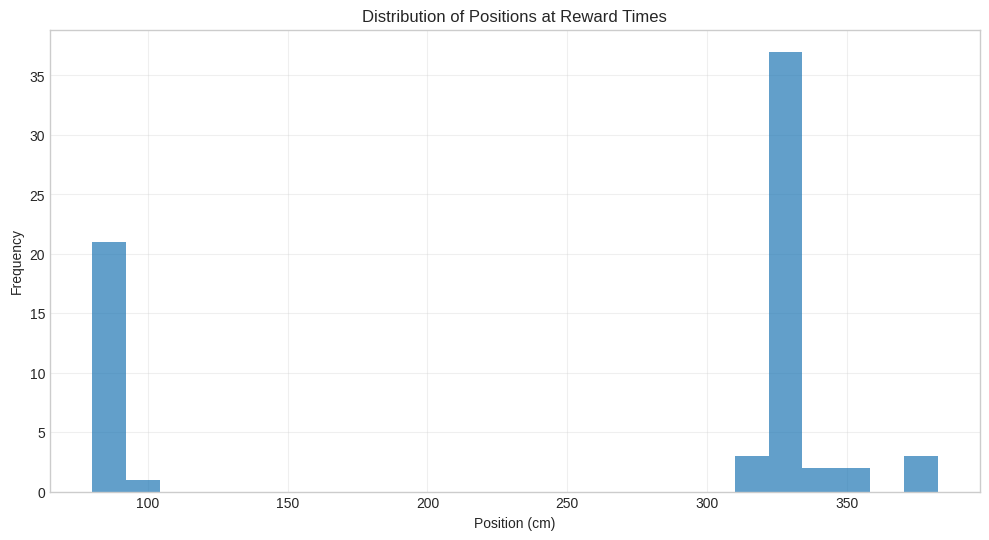

In [13]:
# Create a figure showing position at reward times
plt.figure(figsize=(12, 6))

# Get position at times close to reward delivery
reward_positions = []
for reward_time in reward_timestamps:
    # Find the closest position timestamp to the reward time
    idx = np.abs(position_timestamps - reward_time).argmin()
    reward_positions.append(position_data[idx])

plt.hist(reward_positions, bins=25, alpha=0.7)
plt.xlabel('Position (cm)')
plt.ylabel('Frequency')
plt.title('Distribution of Positions at Reward Times')
plt.grid(True, alpha=0.3)
plt.show()

## Neural Activity Data

Now let's explore the neural activity data from the two-photon calcium imaging.

In [14]:
# Access the ophys processing module
ophys = nwb.processing["ophys"]

# Get the available data interfaces
ophys_data_interfaces = list(ophys.data_interfaces.keys())
print("Available ophys data interfaces:", ophys_data_interfaces)

Available ophys data interfaces: ['Backgrounds_0', 'Deconvolved', 'Fluorescence', 'ImageSegmentation', 'Neuropil']


### Examining the Fluorescence Data

Let's look at the fluorescence traces from some example neurons:

Fluorescence data shape: 20684 timepoints x 358 neurons


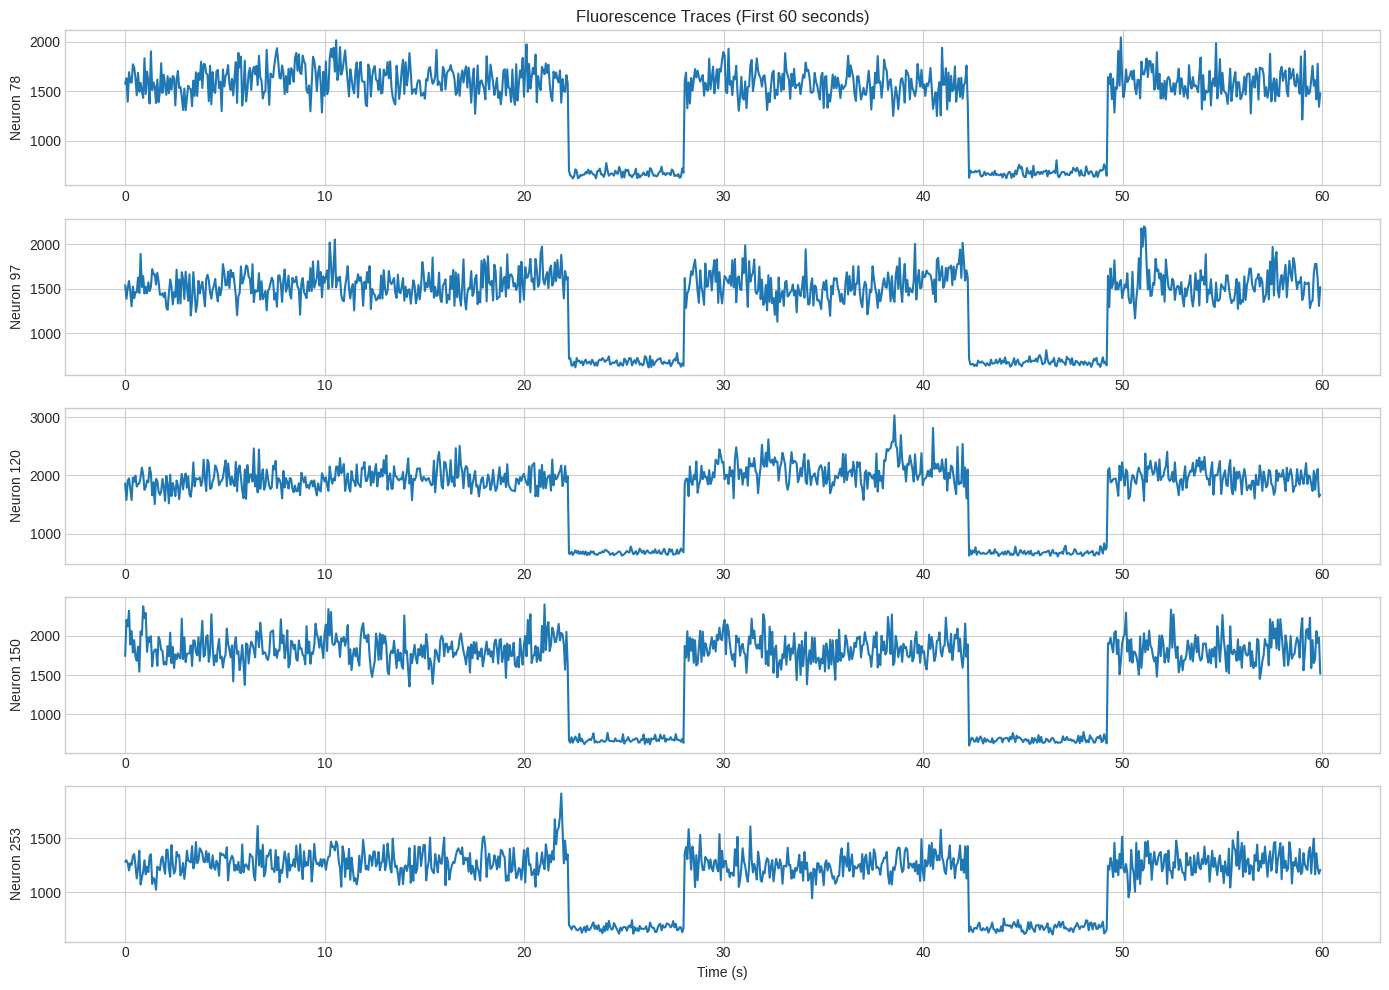

In [15]:
# Get the fluorescence data
fluorescence = ophys.data_interfaces["Fluorescence"]
roi_response_series = fluorescence.roi_response_series["plane0"]

# Get the data dimensions
num_timepoints, num_neurons = roi_response_series.data.shape
print(f"Fluorescence data shape: {num_timepoints} timepoints x {num_neurons} neurons")

# Get the fluorescence data for a few example neurons
n_example_neurons = 5
example_neuron_ids = np.sort(np.random.choice(num_neurons, n_example_neurons, replace=False))
example_traces = roi_response_series.data[:, example_neuron_ids]

# Get the timestamps
timestamps = np.arange(len(example_traces)) / roi_response_series.rate

# Plot the fluorescence traces
plt.figure(figsize=(14, 10))
for i in range(n_example_neurons):
    plt.subplot(n_example_neurons, 1, i+1)
    plt.plot(timestamps[:int(60*roi_response_series.rate)], example_traces[:int(60*roi_response_series.rate), i])
    plt.ylabel(f'Neuron {example_neuron_ids[i]}')
    if i == 0:
        plt.title('Fluorescence Traces (First 60 seconds)')
    if i == n_example_neurons - 1:
        plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

### ROI/Cell Segmentation Data

Let's examine information about the segmented cells (ROIs):

Number of ROIs: 358

ROI DataFrame columns:
Index(['pixel_mask', 'iscell', 'planeIdx'], dtype='object')

First few rows:
                                           pixel_mask  \
id                                                      
0   [[184, 477, 20.42091], [184, 478, 24.655317], ...   
1   [[220, 548, 17.799917], [220, 549, 21.690094],...   
2   [[198, 485, 19.04672], [198, 486, 17.522465], ...   
3   [[172, 531, 11.773818], [172, 532, 19.495077],...   
4   [[148, 465, 16.043055], [148, 466, 19.642868],...   

                       iscell  planeIdx  
id                                       
0   [1.0, 0.9996045543367583]         0  
1   [1.0, 0.9983935935458714]         0  
2   [1.0, 0.9993062048252185]         0  
3   [1.0, 0.9719317970495572]         0  
4   [1.0, 0.9211749203309639]         0  

First few iscell values: [array([1.        , 0.99960455]), array([1.        , 0.99839359]), array([1.       , 0.9993062]), array([1.       , 0.9719318]), array([1.        , 0.92117492]

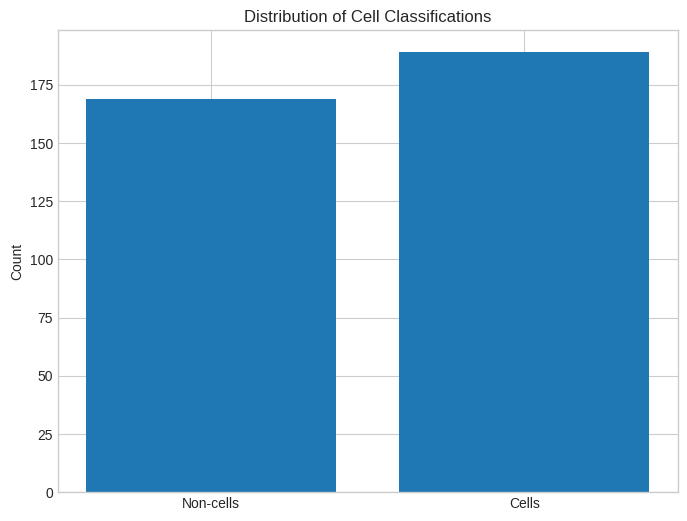

In [16]:
# Get the segmentation data
image_segmentation = ophys.data_interfaces["ImageSegmentation"]
plane_segmentation = image_segmentation.plane_segmentations["PlaneSegmentation"]

# Convert to a dataframe for easier viewing
roi_df = plane_segmentation.to_dataframe()
print(f"Number of ROIs: {len(roi_df)}")
print("\nROI DataFrame columns:")
print(roi_df.columns)
print("\nFirst few rows:")
print(roi_df.head())

# Let's check if there's cell classification information
if 'iscell' in roi_df.columns:
    # Check the first few values of iscell
    iscell_first_few = [plane_segmentation.iscell[i] for i in range(min(5, len(plane_segmentation.iscell)))]
    print("\nFirst few iscell values:", iscell_first_few)
    
    # If iscell is multi-column data, try to extract the first column (usually is_cell classification)
    try:
        is_cell = np.array([cell[0] for cell in plane_segmentation.iscell[:]])
        print(f"\nNumber of classified cells: {np.sum(is_cell)}/{len(is_cell)}")
        
        # Plot distribution of cell vs non-cell ROIs
        plt.figure(figsize=(8, 6))
        plt.bar(['Non-cells', 'Cells'], [len(is_cell) - np.sum(is_cell), np.sum(is_cell)])
        plt.ylabel('Count')
        plt.title('Distribution of Cell Classifications')
        plt.show()
    except:
        print("Could not parse iscell values as expected.")

### Exploring Background Images

Let's check if we have background images like mean image or max projection:

Available background images: ['Vcorr', 'max_proj', 'meanImg']


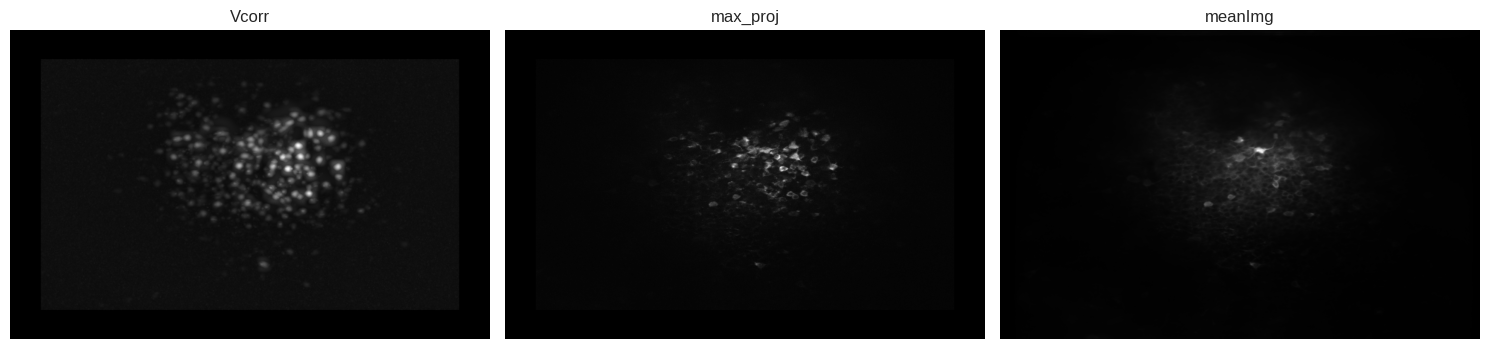

In [17]:
# Check for background images
if "Backgrounds_0" in ophys.data_interfaces:
    backgrounds = ophys.data_interfaces["Backgrounds_0"]
    available_images = list(backgrounds.images.keys())
    print("Available background images:", available_images)
    
    # Plot the images if available
    fig, axes = plt.subplots(1, len(available_images), figsize=(15, 5))
    
    if len(available_images) == 1:
        axes = [axes]  # Make it iterable when there's only one image
        
    for i, img_name in enumerate(available_images):
        if img_name in backgrounds.images:
            img = backgrounds.images[img_name].data
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(img_name)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No background images available")

## Relating Neural Activity to Behavior

Let's examine how neural activity relates to the animal's position in the environment.

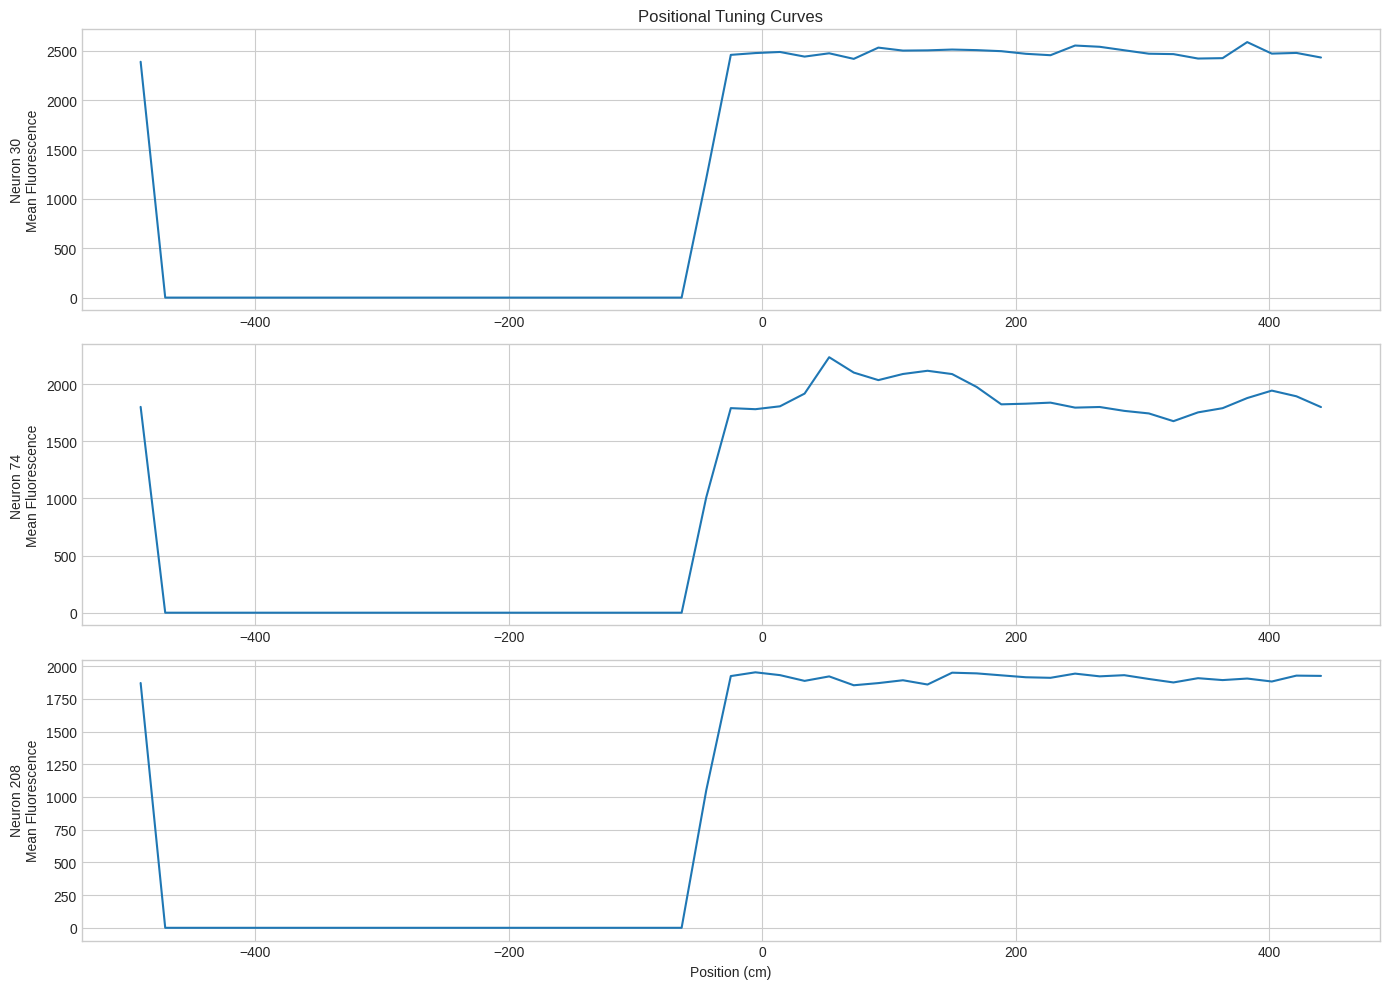

In [18]:
# Get fluorescence data
fluorescence_data = roi_response_series.data
timestamps = np.arange(len(fluorescence_data)) / roi_response_series.rate

# Get position data (match the timestamps with the fluorescence data)
position_data_resampled = np.interp(timestamps, position_timestamps, position_data)

# Select a few neurons to analyze - ensure indices are sorted for h5py indexing
n_neurons_to_plot = 3
selected_neurons = np.sort(np.random.choice(num_neurons, n_neurons_to_plot, replace=False))

# Create a figure for positional tuning curves
plt.figure(figsize=(14, 10))

# Define position bins
pos_bins = np.linspace(np.min(position_data), np.max(position_data), 50)
bin_centers = (pos_bins[1:] + pos_bins[:-1]) / 2

# For each selected neuron
for i, neuron_idx in enumerate(selected_neurons):
    # Get fluorescence data for this neuron
    neuron_data = fluorescence_data[:, neuron_idx]
    
    # Calculate mean fluorescence at each position
    mean_fluo = np.zeros(len(pos_bins)-1)
    for j in range(len(pos_bins)-1):
        in_bin = (position_data_resampled >= pos_bins[j]) & (position_data_resampled < pos_bins[j+1])
        if np.sum(in_bin) > 0:
            mean_fluo[j] = np.mean(neuron_data[in_bin])
    
    # Plot the positional tuning curve
    plt.subplot(n_neurons_to_plot, 1, i+1)
    plt.plot(bin_centers, mean_fluo)
    plt.ylabel(f'Neuron {neuron_idx}\nMean Fluorescence')
    
    if i == 0:
        plt.title('Positional Tuning Curves')
    
    if i == n_neurons_to_plot - 1:
        plt.xlabel('Position (cm)')

plt.tight_layout()
plt.show()

Let's examine neural activity around reward delivery by looking at individual neuron responses:

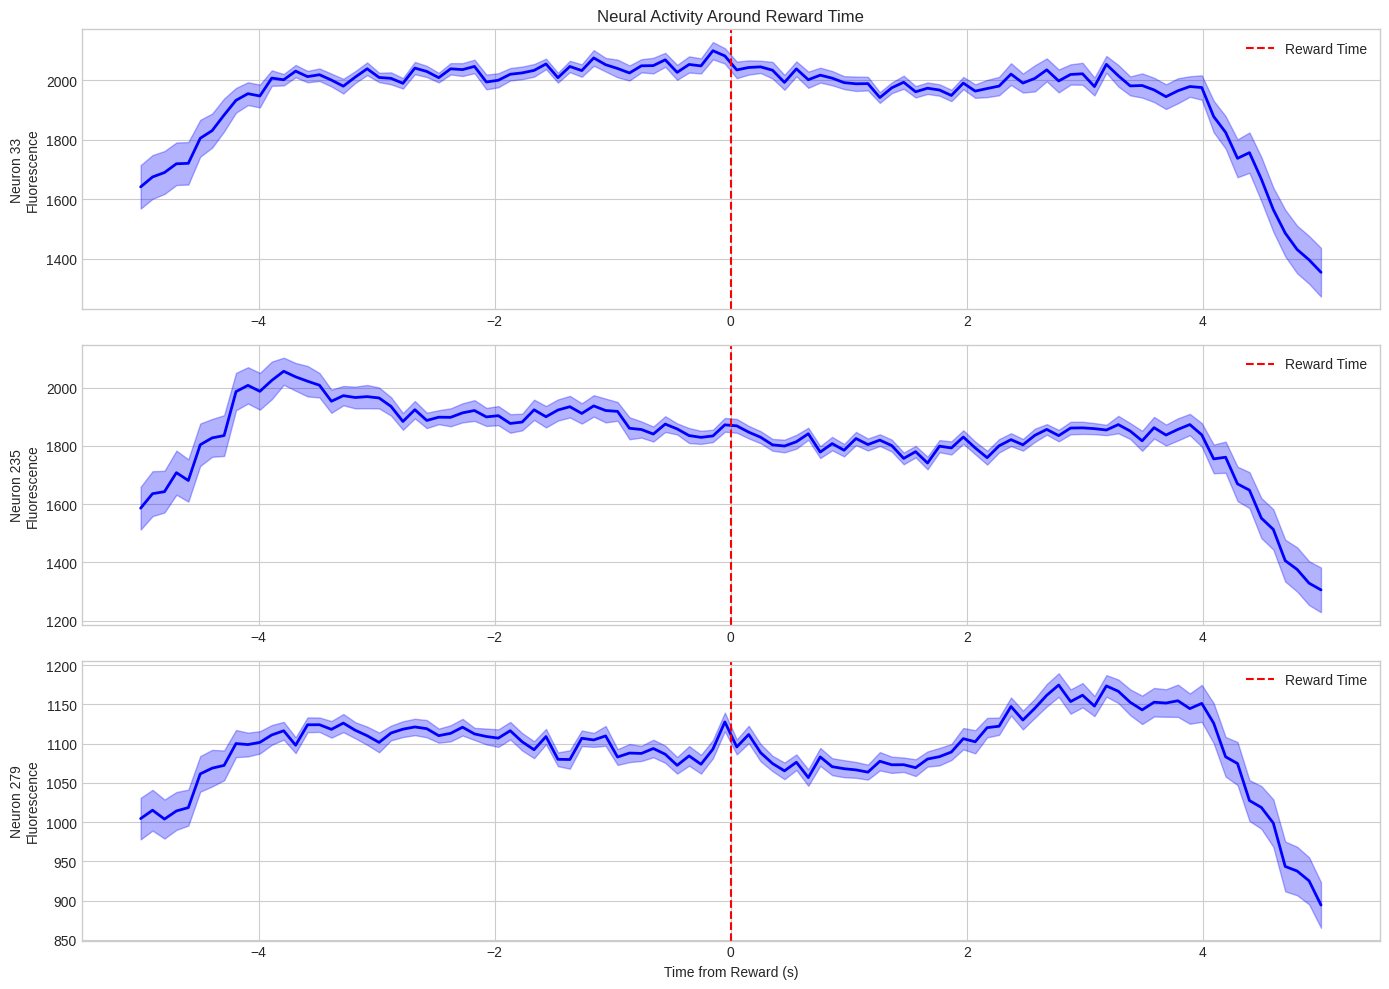

In [19]:
# Create peri-reward time histograms for a few neurons
time_window = 5  # seconds before and after reward
n_neurons_to_plot = 3
selected_neurons = np.sort(np.random.choice(num_neurons, n_neurons_to_plot, replace=False))

# Create a figure
plt.figure(figsize=(14, 10))

# Define time bins around reward
time_bins = np.linspace(-time_window, time_window, 100)
bin_width = time_bins[1] - time_bins[0]

for i, neuron_idx in enumerate(selected_neurons):
    # Get data for this neuron
    neuron_data = fluorescence_data[:, neuron_idx]
    
    # For each reward, collect activity
    all_trials = []
    
    for reward_time in reward_timestamps:
        # Find indices in the fluorescence data corresponding to this window
        start_time = reward_time - time_window
        end_time = reward_time + time_window
        
        trial_data = []
        
        # Get activity around each reward time
        for t in time_bins:
            # Find the closest timestamp
            target_time = reward_time + t
            idx = np.argmin(np.abs(timestamps - target_time))
            
            # Add data point if within range
            if 0 <= idx < len(neuron_data):
                trial_data.append(neuron_data[idx])
            else:
                trial_data.append(np.nan)  # Out of bounds
        
        if not all(np.isnan(trial_data)):
            all_trials.append(trial_data)
    
    # Average across trials
    if all_trials:
        mean_activity = np.nanmean(all_trials, axis=0)
        sem_activity = np.nanstd(all_trials, axis=0) / np.sqrt(np.sum(~np.isnan(all_trials), axis=0))
        
        # Create subplot for this neuron
        ax = plt.subplot(n_neurons_to_plot, 1, i+1)
        
        # Plot mean and SEM
        ax.plot(time_bins, mean_activity, 'b-', linewidth=2)
        ax.fill_between(time_bins, 
                        mean_activity - sem_activity, 
                        mean_activity + sem_activity, 
                        alpha=0.3, color='b')
        
        # Add a vertical line at reward time
        ax.axvline(x=0, color='r', linestyle='--', label='Reward Time')
        
        # Labels
        ax.set_ylabel(f'Neuron {neuron_idx}\nFluorescence')
        if i == 0:
            ax.set_title('Neural Activity Around Reward Time')
        if i == n_neurons_to_plot - 1:
            ax.set_xlabel('Time from Reward (s)')
        
        ax.legend()

plt.tight_layout()
plt.show()

## Summary

In this notebook, we've explored Dandiset 001361, which contains two-photon calcium imaging data from hippocampal CA1 neurons during virtual navigation. We've:

1. Examined the Dandiset metadata and structure
2. Loaded and explored an NWB file
3. Visualized behavioral data such as position, speed, licking, and rewards
4. Examined neural activity patterns using fluorescence data
5. Analyzed the relationship between neural activity and behavioral events

This exploration provides a foundation for further analysis such as:
- Detailed place cell identification and mapping
- Analysis of reward-related neural responses
- Investigation of how hippocampal representations change with learning
- Population-level analyses of neural ensembles

The data structure is well-organized within the NWB format, making it accessible for various neuroscience analyses.